In [3]:
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing, model_selection
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot
import plotly.express as px
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score


recall: 0.8103


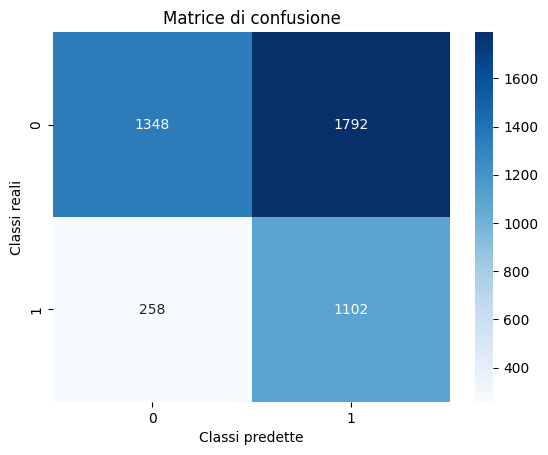

In [4]:
df =pd.read_csv("aids_clean.csv")
df = df.drop(columns=['hemo','drugs'])

df['trt'] = df['trt'].astype('object')
df['strat'] = df['strat'].astype('object')
df = pd.get_dummies(df, columns=['trt', 'strat'])

df.head()

X = df.drop('infected', axis=1)  
y = df['infected'].astype(int)  # Assicurati che y sia di tipo int (binario)
X_encoded = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=56)

best_params = {
    'objective':'binary:logistic',
    'subsample': 0.6, 
    'scale_pos_weight': 4, 
    'reg_lambda': 5, 
    'reg_alpha': 5, 
    'min_child_weight': 1, 
    'max_depth': 3, 
    'gamma': 0.3, 
    'colsample_bytree': 0.8}

#fit the model on train set
xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

# Predictions on  test set
y_pred = xgb_clf.predict(X_test)

#calculate the recall
recall = recall_score(y_test, y_pred)
print('recall: {0:0.4f}'.format(recall))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Classi predette')
plt.ylabel('Classi reali')
plt.title('Matrice di confusione')
plt.show()

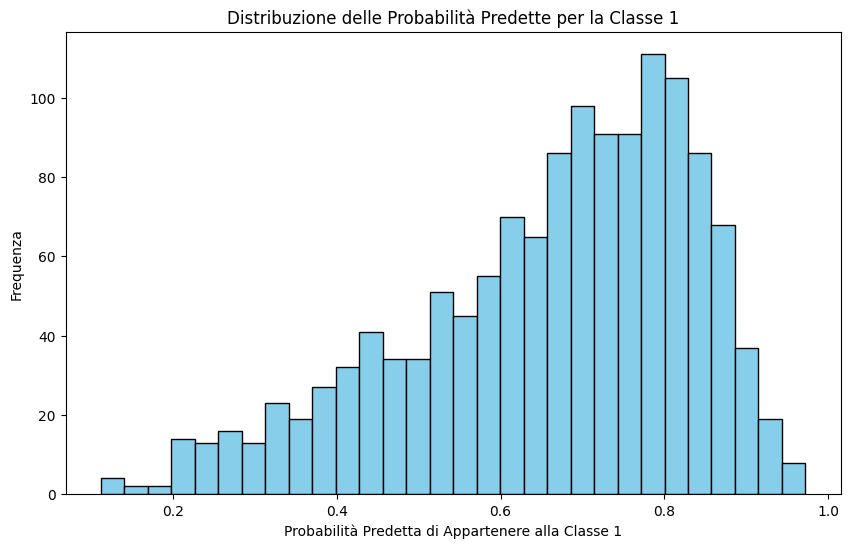

In [5]:
y_pred_pro = xgb_clf.predict_proba(X_test)[:, 1]  # Probabilità della classe positiva
y_pred_pro_list = y_pred_pro.tolist()

# Crea un DataFrame con y_test e y_pred_pro
df = pd.DataFrame({'y_test': y_test, 'y_pred_pro': y_pred_pro})

# Filtra e ordina
df_filtered_sorted = df[df['y_test'] == 1].sort_values(by='y_pred_pro', ascending=False)

# Crea l'istogramma
plt.figure(figsize=(10, 6))
plt.hist(df_filtered_sorted['y_pred_pro'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe 1')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe 1')
plt.ylabel('Frequenza')
plt.show()

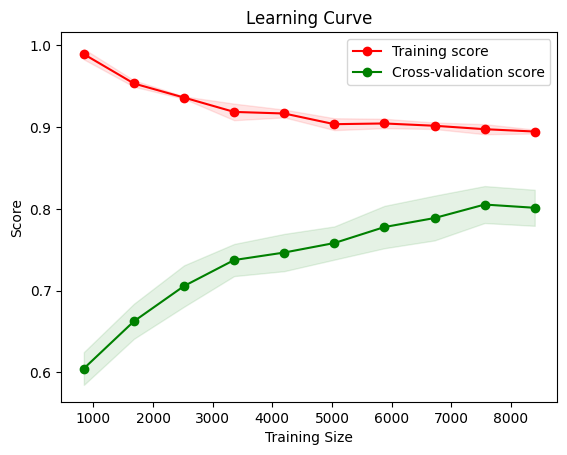

In [6]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, recall_score
train_sizes, train_scores, test_scores = learning_curve(xgb_clf, X_train, y_train, cv=5, scoring='recall', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

##### Interpretable Machine Learning methods

##### Feature importance
###### Feature importance is given as how much the variable is able not to loss any information

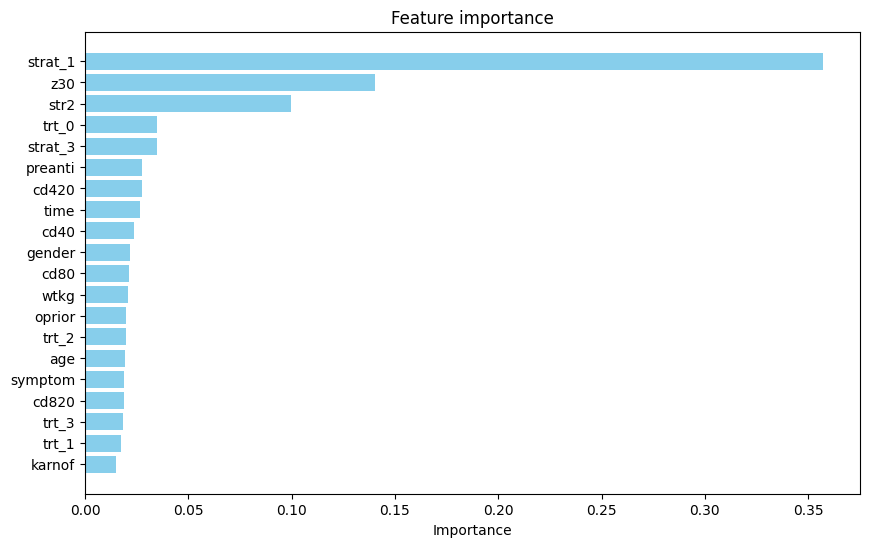

In [7]:
importance = xgb_clf.feature_importances_
features = X_test.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20), color='skyblue')
plt.xlabel('Importance')
plt.title('Feature importance')
plt.gca().invert_yaxis() 
plt.show()

###### Partial dependence plot

###### time, trt, age, wtkg, karnof, = the prediction range is usually between 0.5 and 0.65 (this feature is not so useful)
###### 

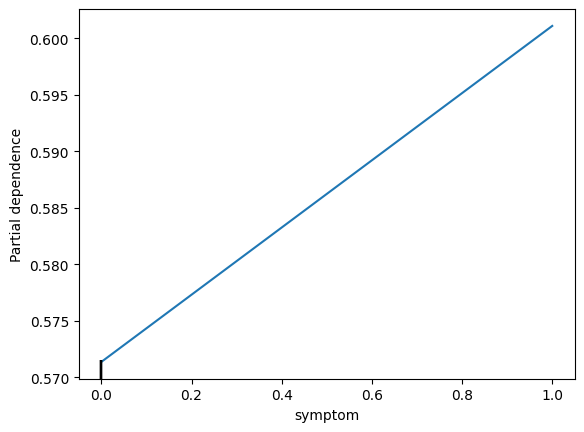

In [8]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(xgb_clf, 
                                        X_test, 
                                        ['symptom'])

###### Accumulated local efffects

PyALE._ALE_generic:INFO: Discrete feature detected.


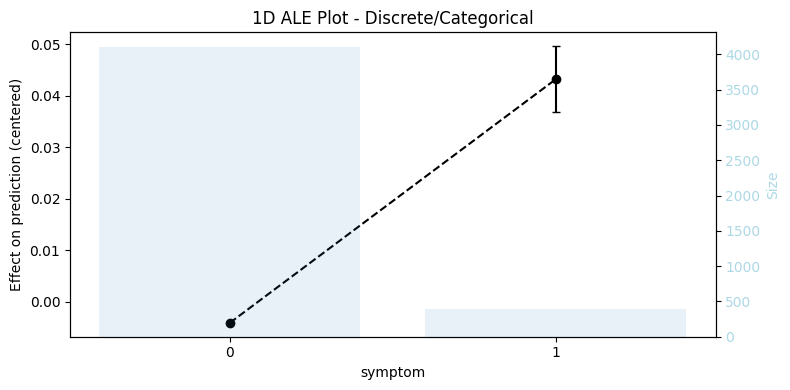

In [9]:
from PyALE import ale

features = X_test.columns.tolist()
ale_eff = ale(X = X_test[features], model = xgb_clf, feature = ['symptom'], grid_size = 50)

###### Individual conditional expectations plot

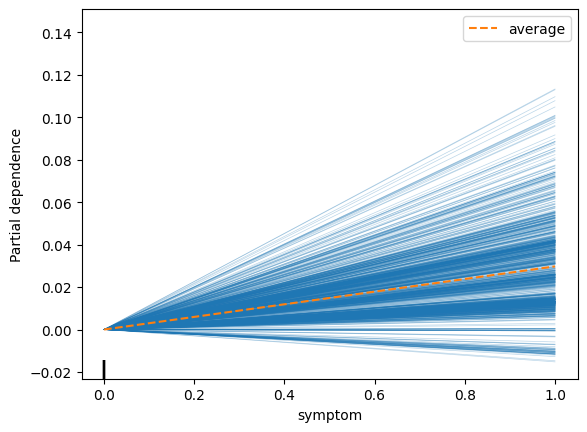

In [10]:
from sklearn.inspection import PartialDependenceDisplay

features_info = {
    "features": ["symptom"],
    "kind": "both",
    "centered": True,
}
PartialDependenceDisplay.from_estimator(
    xgb_clf,
    X_test,
    **features_info
)

###### Shapley values

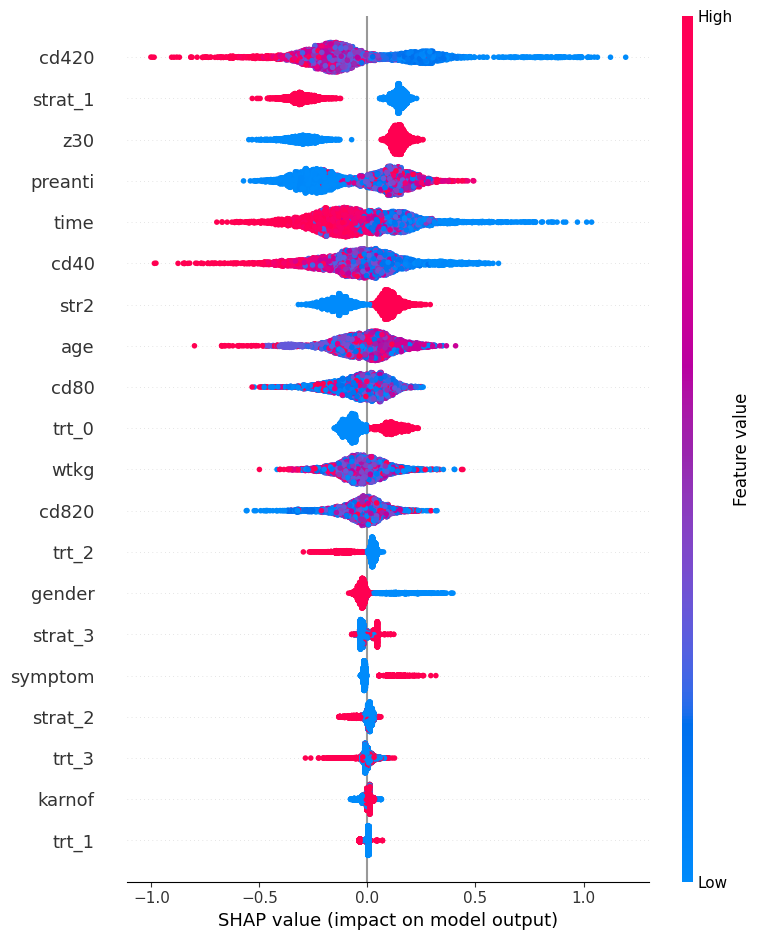

In [11]:
import shap
#Calcolo dei valori SHAP
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer(X_test)
expected_value = explainer.expected_value #valore atteso delle previsioni del modello

# Genera il plot SHAP summary
shap.summary_plot(shap_values, X_test, title="SHAP summary plot")


In [12]:
predictions_proba = xgb_clf.predict_proba(X_test)
positive_class_proba = predictions_proba[:, 1]

# Find True Positives
true_positive_indices = np.where((positive_class_proba > 0.5) & (y_test == 1))[0]
print("True positives instances:")
np.set_printoptions(threshold=np.inf)
print(true_positive_indices)
print("Number of True positives: ",len(true_positive_indices))

True positives instances:
[   0    5   10   13   15   26   28   31   34   41   58   61   65   67
   68   71   73   76   82   84   87   99  100  112  120  121  122  131
  137  139  143  149  155  157  158  160  171  175  178  179  181  184
  196  198  202  203  215  217  221  223  224  232  233  234  235  242
  247  254  256  258  261  262  265  272  275  276  279  284  288  293
  295  300  301  303  306  311  313  316  318  333  337  338  345  346
  349  354  355  357  363  367  370  371  375  377  382  386  395  402
  407  410  413  421  425  430  432  436  447  448  451  462  463  465
  466  472  479  481  484  486  489  494  502  503  506  509  513  517
  536  544  546  553  556  562  564  565  566  568  572  573  577  578
  579  582  584  597  598  600  601  604  608  612  613  620  628  633
  636  638  641  642  646  648  655  658  659  660  661  663  664  667
  673  682  689  690  694  697  698  700  702  722  736  744  747  750
  755  757  758  760  762  768  773  780  781  785 

In [13]:
# Find False negatives
false_negatives_indices = np.where((positive_class_proba < 0.5) & (y_test == 1))[0]
print("False negatives instances:")
print(false_negatives_indices)
print("Number of False negatives: ",len(false_negatives_indices))

False negatives instances:
[   6   11   29   47   53   62   66  104  106  107  118  146  174  197
  267  269  305  314  321  323  328  343  352  364  365  373  403  406
  409  418  419  459  475  499  504  523  589  596  610  615  616  617
  621  699  703  724  767  771  783  790  808  820  821  828  862  888
  897  900  912  913  915  936  939  988  999 1004 1027 1045 1057 1058
 1059 1078 1084 1092 1123 1130 1133 1139 1140 1146 1174 1251 1253 1293
 1325 1355 1360 1424 1453 1478 1479 1491 1503 1518 1594 1600 1609 1610
 1669 1673 1676 1693 1698 1705 1745 1755 1801 1816 1817 1843 1877 1893
 1894 1905 1935 1951 1964 1978 1999 2022 2072 2074 2098 2106 2142 2146
 2211 2222 2243 2262 2298 2314 2321 2327 2335 2349 2386 2403 2405 2436
 2438 2460 2471 2508 2535 2562 2625 2632 2634 2650 2661 2734 2760 2890
 2915 2929 2938 2967 3000 3073 3084 3088 3136 3161 3198 3226 3239 3252
 3273 3281 3284 3292 3295 3298 3338 3344 3368 3370 3382 3383 3387 3409
 3415 3452 3455 3477 3486 3519 3522 3532 3564 3601

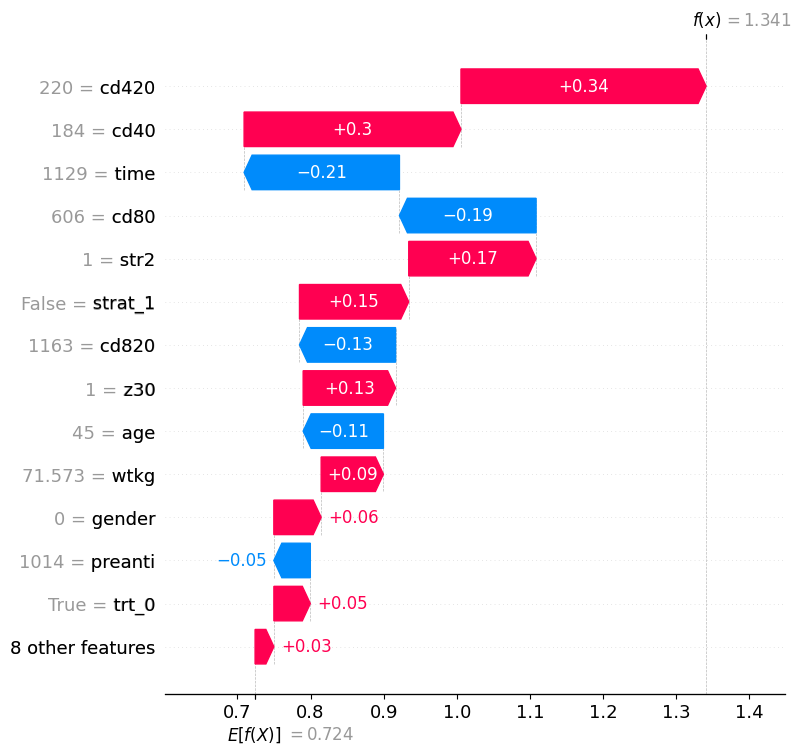

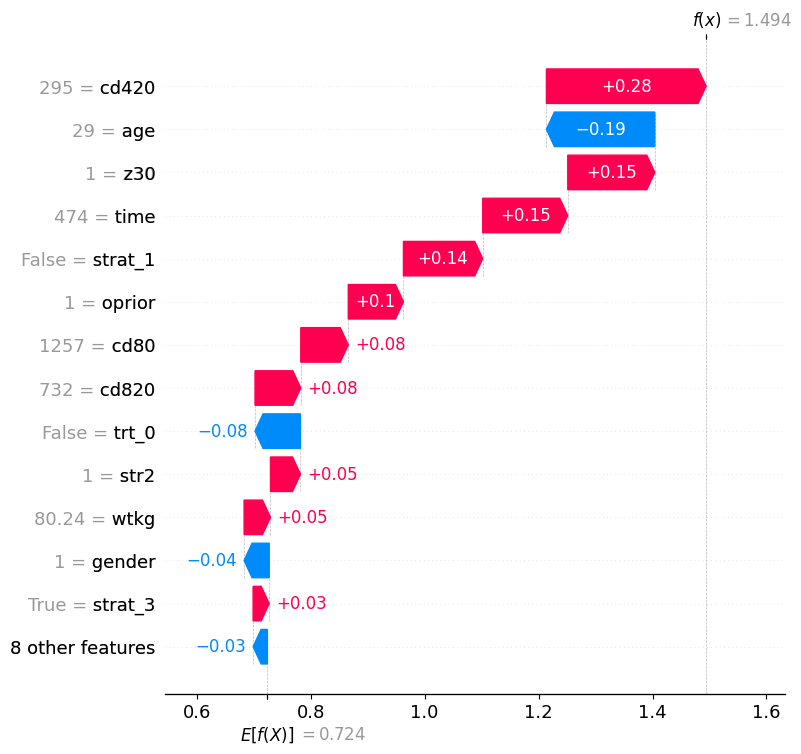

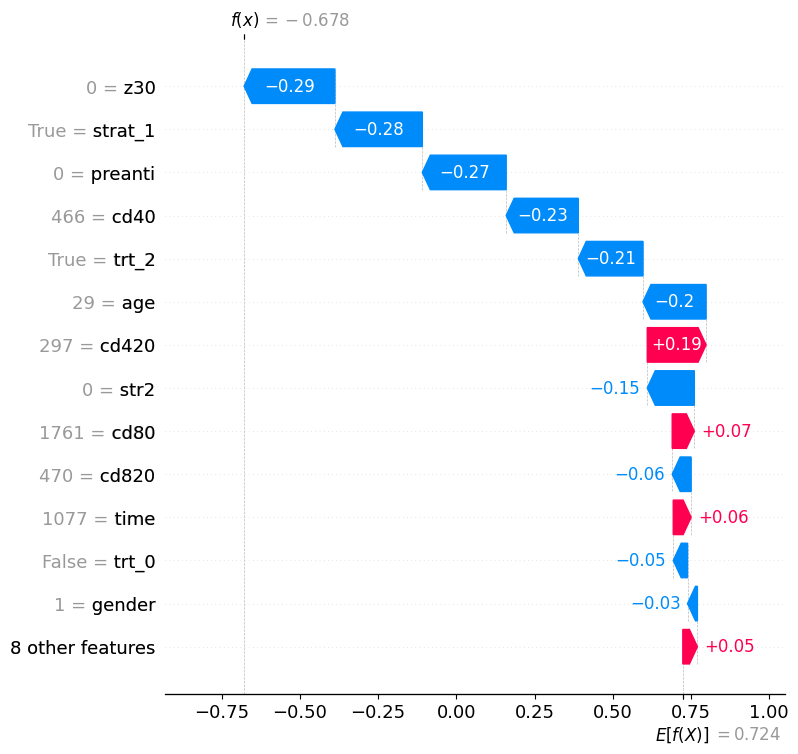

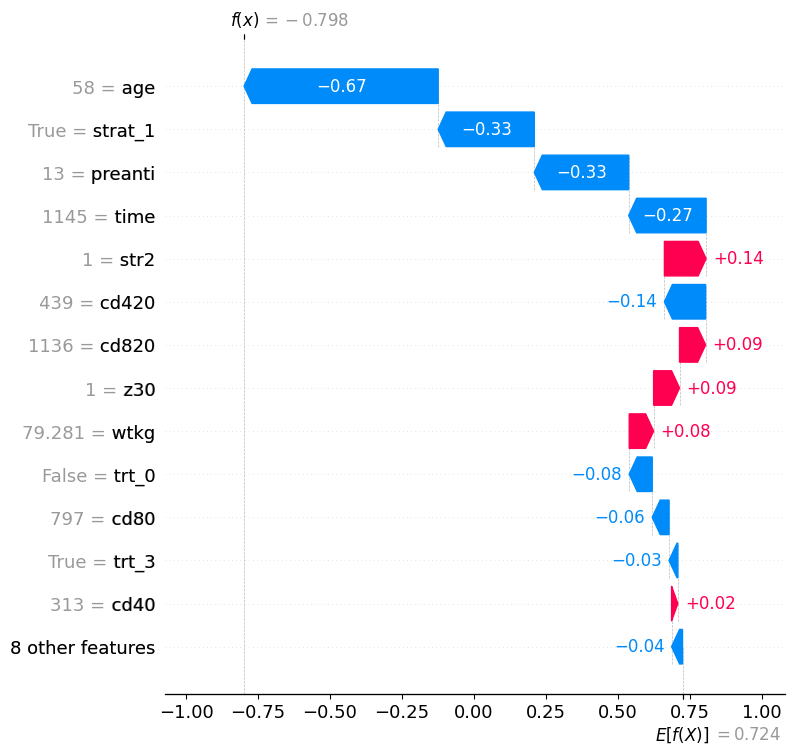

In [14]:
#TP
shap.plots.waterfall(shap_values[4333], max_display=14)
shap.plots.waterfall(shap_values[311], max_display=14)

#FN
shap.plots.waterfall(shap_values[6], max_display=14)
shap.plots.waterfall(shap_values[53], max_display=14)

###### lime

In [15]:
import lime
from lime import lime_tabular

# Create LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_test.values,
    feature_names=X_test.columns.tolist(),
    class_names=['not_infected', 'infected'],  # Include both classes
    verbose=True, 
    mode='classification')

In [16]:
# Explain instance using predict_proba
exp = explainer_lime.explain_instance(X_test.values[6], xgb_clf.predict_proba, num_features=10)

# Show the explanations in notebook
exp.show_in_notebook(show_table=True)

Intercept 0.7648149236927003
Prediction_local [0.42551714]
Right: 0.3366077


###### anchors

In [17]:
from anchor import anchor_tabular

# Imposta i nomi delle variabili e delle classi
feature_names = X_test.columns
class_names = sorted([str(cls) for cls in y.unique()])

# Crea l'explainer per i dati tabulari
explainer = anchor_tabular.AnchorTabularExplainer(
    class_names=class_names,
    feature_names=feature_names,
    train_data=X_test.values
)

np.random.seed(22)

sample_to_explain = X_test.iloc[6].values
'''0    5   10   13   15   26   28   31   34   41   58   61   62   65'''
print("Model classes:", xgb_clf.classes_)
print("Explainer classes:", class_names)

# Crea la spiegazione usando il modello xgb_clf
exp = explainer.explain_instance(sample_to_explain, xgb_clf.predict)

# Stampa precisione e copertura della spiegazione
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

print("Anchor precision:", exp.precision())
print("Anchor coverage:", exp.coverage())
exp.show_in_notebook()


Model classes: [0 1]
Explainer classes: ['0', '1']
Precision: 0.96
Coverage: 0.06
Anchor precision: 0.9550561797752809
Anchor coverage: 0.0579


In [18]:
# Stampa le classi del modello
print("Model classes:", xgb_clf.classes_)

# Stampa le classi passate all'Anchor Explainer
print("Explainer classes:", class_names)


Model classes: [0 1]
Explainer classes: ['0', '1']


#### Analyze all False negatives

In [19]:
indices = [
    6, 11, 29, 47, 53, 104, 106, 118, 146, 174, 224, 256, 262, 267,
    269, 305, 306, 313, 321, 323, 343, 352, 365, 373, 403, 406, 409, 419,
    486, 499, 502, 504, 556, 589, 610, 615, 616, 617, 620, 621, 699, 724,
    744, 767, 783, 821, 828, 862, 881, 888, 897, 900, 912, 915, 936, 939,
    999, 1004, 1027, 1038, 1045, 1058, 1059, 1078, 1084, 1092, 1123, 1130,
    1133, 1139, 1140, 1146, 1174, 1231, 1253, 1278, 1325, 1355, 1424, 1453,
    1459, 1478, 1479, 1491, 1503, 1518, 1569, 1591, 1594, 1600, 1609, 1610,
    1668, 1673, 1676, 1705, 1734, 1739, 1745, 1749, 1755, 1788, 1801, 1816,
    1817, 1818, 1843, 1877, 1880, 1893, 1894, 1905, 1918, 1935, 1951, 1964,
    1978, 1999, 2022, 2058, 2072, 2074, 2135, 2142, 2146, 2154, 2164, 2211,
    2243, 2262, 2314, 2321, 2327, 2335, 2349, 2386, 2403, 2405, 2436, 2460,
    2471, 2535, 2562, 2565, 2625, 2632, 2634, 2661, 2665, 2705, 2734, 2743,
    2760, 2890, 2906, 2926, 2929, 2938, 3000, 3002, 3079, 3080, 3088, 3161,
    3198, 3226, 3239, 3252, 3273, 3281, 3284, 3292, 3295, 3344, 3356, 3370,
    3382, 3383, 3387, 3409, 3415, 3455, 3480, 3486, 3519, 3532, 3535, 3564,
    3617, 3635, 3660, 3664, 3665, 3683, 3747, 3755, 3765, 3770, 3780, 3786,
    3807, 3810, 3812, 3835, 3869, 3898, 3903, 3907, 3938, 3962, 3980, 3993,
    4012, 4013, 4026, 4029, 4053, 4086, 4092, 4107, 4115, 4129, 4155, 4171,
    4189, 4203, 4206, 4266, 4301, 4329, 4342, 4347, 4357, 4368, 4378, 4403,
    4409, 4415, 4434, 4443, 4457, 4467, 4476
]

###### Shap analysis

In [21]:
#for idx in indices:
    #shap.plots.waterfall(shap_values[idx], max_display=14)

###### lime analysis

In [22]:
#for idx in indices:
    #xplainer_lime = lime.lime_tabular.LimeTabularExplainer(
    #X_test.values,
    #feature_names=X_test.columns.tolist(),
    #class_names=['not_infected', 'infected'],  # Include both classes
    #verbose=True, 
    #mode='classification')
    
    # Explain instance using predict_proba
    #exp = explainer_lime.explain_instance(X_test.values[idx], xgb_clf.predict_proba, num_features=10)

    # Show the explanations in notebook
    #exp.show_in_notebook(show_table=True)